In [1]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import pandas as pd
import os
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing as mp
from IPython.core.debugger import set_trace
from IPython.display import clear_output

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
import copy

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from umap import UMAP

import torch
from torch import nn
from torch import optim
from torch import autograd

from torch.utils.data import DataLoader

from train_utils import get_capacity, plot_weights_hist, train, get_grad_params
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         l2_loss, \
                         to_numpy, \
                         numpy_metric, \
                         cosine_sim

from input_utils import DataGenerator, make_random_affine
from models_utils import MLP_NonlinearEncoder, \
                         init_weights, \
                         universal_approximator, \
                         dJ_criterion, \
                         gained_function, \
                         adjust_learning_rate, \
                         compute_joint_probabilities, \
                         tsne_loss,\
                         tsne_criterion, \
                         sigmoid, \
                         initialize_nonlinearities

from embedding_utils import ConstructUMAPGraph, UMAPLoss, UMAPDataset, umap_criterion_compatibility

from pynndescent import NNDescent
from umap.umap_ import fuzzy_simplicial_set, make_epochs_per_sample
from sklearn.utils import check_random_state

import pygad
from torchga import TorchGA, model2vector, vector2model

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
N_CPU = mp.cpu_count()
SEED = 42
%autoreload 2

# Load data 

In [2]:
SCALER = StandardScaler()

input_parameters = {'generator': make_swiss_roll, #make_s_curve, 
                    'generator_kwargs': {'n_samples':10000, 'noise':1e-2}, # 1e-1
                    'unsupervised':True,
                    'whiten':True,
                    'scaler':SCALER,
                    'use_outpt_color':True} 

create_data = DataGenerator(**input_parameters)

inpt, _, color = create_data()

N_TEST = 1000

In [3]:
inpt.mean(1), inpt.std(1)

(array([ 2.73558953e-17,  2.60769184e-16, -1.81188398e-17]),
 array([1., 1., 1.]))

In [4]:
inpt.max(1), inpt.min(1), inpt@inpt.T / inpt.shape[1]

(array([1.61124226, 1.73030898, 2.00029622]),
 array([-1.72730969, -1.7544607 , -1.61003368]),
 array([[1.00000000e+00, 8.47008060e-04, 9.87281615e-02],
        [8.47008060e-04, 1.00000000e+00, 5.09400474e-03],
        [9.87281615e-02, 5.09400474e-03, 1.00000000e+00]]))

In [5]:
inpt_train, inpt_test, color_train, color_test = train_test_split(inpt.T, 
                                                                  color, 
                                                                  random_state=42,
                                                                  test_size=N_TEST)

In [6]:
inpt_train_torch = torch.tensor(inpt_train, dtype=torch.float32).to(device)
inpt_test_torch = torch.tensor(inpt_test, dtype=torch.float32).to(device)

In [7]:
(inpt_train_torch.T@inpt_train_torch / inpt_train_torch.shape[0]).round()

tensor([[1., -0., 0.],
        [-0., 1., -0.],
        [0., -0., 1.]], device='cuda:0')

In [8]:
inpt_train_torch.mean(0), inpt_train_torch.std(0)

(tensor([-0.0009, -0.0037, -0.0050], device='cuda:0'),
 tensor([0.9996, 1.0004, 1.0023], device='cuda:0'))

In [9]:
inpt_train_torch.shape, inpt_test_torch.shape

(torch.Size([9000, 3]), torch.Size([1000, 3]))

In [10]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(inpt.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

# PCA

In [11]:
N_CYCLES = 1
data = [create_data()  for _ in range(N_CYCLES)]
inpt_data = np.concatenate([d[0] for d in data],-1)
outpt_data = np.concatenate([d[1] for d in data],-1)

3


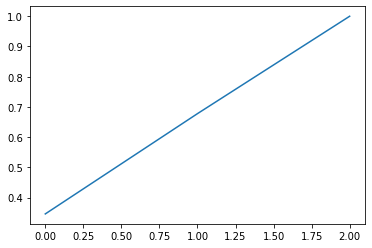

In [12]:
pca = PCA()
Z_pca = pca.fit_transform(inpt_data.T)
pca_ev = np.cumsum(pca.explained_variance_ratio_)
print((np.arange(1,inpt_data.shape[0]+1)[pca_ev > 0.99])[0])
plt.plot(pca_ev)
plt.show()

In [13]:
# plt.scatter(Z_pca[:,0], Z_pca[:,1], c=outpt_data[0])
# plt.colorbar()

In [86]:
# Z_pca_test = pca.transform(inpt_test.T)
# plt.scatter(Z_pca_test[:,0], Z_pca_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [87]:
# umap = UMAP(n_components=2, n_neighbors=50, n_jobs=1)
# Z = umap.fit_transform(inpt_data.T)
# Z_test = umap.transform(inpt_test.T)

In [88]:
# plt.scatter(Z[:,0], Z[:,1], c=outpt_data[0])
# plt.colorbar()

In [89]:
# plt.scatter(Z_test[:,0], Z_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [90]:
# Q_loc_val_UMAP, Q_glob_val_UMAP = calculate_Q_metrics(inpt_test.T, Z_test)

In [91]:
# Q_loc_val_UMAP, Q_glob_val_UMAP

# Metalearning: gradient

### Setup training

In [149]:
LEARNING_TYPE = 'Criterion' #'Hebb' 

encoder_parameters = {
                    'input_dim':inpt.shape[0],
                    'hidden_dim':10,
                    'embedding_dim':2,
                    'add_readout':False,
                    'parametrized_f':True,
                    'W_requires_grad':False,
                    'f_requires_grad':True,
                    'final_nonlinearity':False,
                    'nonlinearity': universal_approximator,
                    'f_kwargs':{'hidden_dim':10, 'requires_grad':True},
                    'layers_number':2,
                    'add_bn':False,
                    'seed':None,
                    'set_seed':False,
                     }

def weight_saver(network):
    weights = {}
    for k,v in network.named_parameters():
        weights[k] = to_numpy(v.flatten())
    return weights

training_parameters = edict({'learning_type':LEARNING_TYPE,\
                               'lr':1e-3,
                               'lr_theta':1e-3,
                               'epochs':100,
                               'enable_grad_train':True,
                               'enable_grad_val':False,
                               'maxiter':1000, # maxiter
                               'tol':1e-2, # loss tolerance for early stopping 
                               'wd':1e-3, # weight-decay
                               'progress_bar':True,
                               'weight_saver':weight_saver,
                               'calculate_grad':False,
                               'clip_grad_value': None,
                               'val_metrics':None,
                               'device':device
                             })

criterion_kwargs = defaultdict(dict)
criterion_kwargs['skip_train'] = True
criterion_kwargs['skip_val'] = False

network = MLP_NonlinearEncoder(**encoder_parameters).to(training_parameters['device'])

Net capacity: 260
Parameters:
W_s.0 torch.Size([10, 3]) requires_grad: False Device: cuda:0
W_s.1 torch.Size([2, 10]) requires_grad: False Device: cuda:0
f_s.0.theta1 torch.Size([10, 10]) requires_grad: True Device: cuda:0
f_s.0.bias1 torch.Size([10, 10]) requires_grad: True Device: cuda:0
f_s.0.theta2 torch.Size([1, 10]) requires_grad: True Device: cuda:0


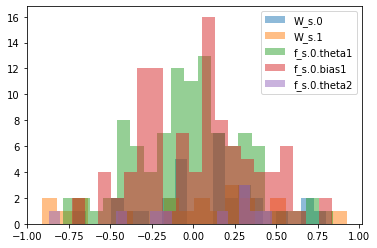

In [150]:
print('Net capacity:', get_capacity(network))
print('Parameters:')

for name, param in network.named_parameters():
    print(name, param.shape, 'requires_grad:', param.requires_grad, 'Device:', param.device)
    W = to_numpy(param.data)
    plt.hist(W.flatten(),bins=20, alpha=0.5, label=f'{name}')
plt.legend()
plt.show()

In [151]:
state_dict = torch.load('./results/mlp_nonlinear/checkpoints/MLP_BP_hdim-10_lnum-2_Wgrad-1_fgrad-1_universal_approximator')
initialize_nonlinearities(network, state_dict)
# network.load_state_dict(state_dict)

f_s from f_s.0.theta1 loaded
f_s from f_s.0.bias1 loaded
f_s from f_s.0.theta2 loaded


### Create datasets

In [152]:
graph_constructor = ConstructUMAPGraph(metric='euclidean', 
                                        n_neighbors=15, 
                                        random_state=SEED)

# (epochs_per_sample, head, tail, weight) 
train_graph_data = graph_constructor(inpt_train)
test_graph_data = graph_constructor(inpt_test)

BATCH_SIZE_BP = 10000

dataset_train = UMAPDataset(inpt_train, 
                            *train_graph_data, 
                            device=training_parameters['device'], 
                            batch_size=BATCH_SIZE_BP)

dataset_test = UMAPDataset(inpt_test, 
                           *test_graph_data, 
                           device=training_parameters['device'],
                           batch_size=BATCH_SIZE_BP)



train_hebb_dataloader = DataLoader(inpt_train_torch.to(training_parameters['device']),
                                       batch_size=10, 
                                       shuffle=True) 
    


Sun Jul 10 15:16:28 2022 Building RP forest with 10 trees
Sun Jul 10 15:16:28 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Sun Jul 10 15:16:29 2022 Building RP forest with 7 trees
Sun Jul 10 15:16:29 2022 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	Stopping threshold met -- exiting after 3 iterations


In [153]:
len(train_hebb_dataloader), len(dataset_test)

(900, 11)

In [154]:
for b in dataset_test:
    print(b.shape)
    break

torch.Size([10000, 3])


### Create criterion

In [155]:
criterion_umap = UMAPLoss(device=training_parameters['device'], 
                         min_dist=0.1,
                         negative_sample_rate=5,
                         edge_weight=None,
                         repulsion_strength=1.0)

criterion = umap_criterion_compatibility(criterion_umap)

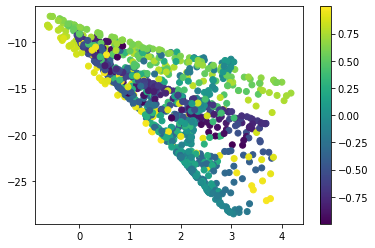

In [156]:
X_s = network.forward(inpt_test_torch.to(training_parameters['device']))
outpt_val_pred = to_numpy(X_s[-1])

plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test
           )
plt.colorbar()
plt.show()

### Training Grad

In [157]:
criterion_kwargs

defaultdict(dict, {'skip_train': True, 'skip_val': False})

In [158]:
# network, _, metric_dict = train(network, 
#                               opt=None, 
#                               criterion=criterion,
#                               criterion_kwargs=criterion_kwargs,
#                               parameters=training_parameters,
#                               train_dataloader=train_hebb_dataloader,
#                               val_dataloader=dataset_test, 
#                               metric_dict=None,
#                               val_metrics=None
#                               )

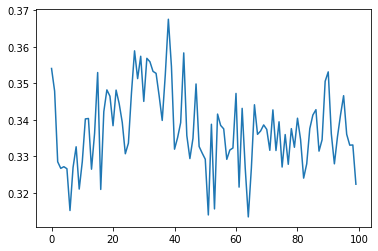

In [121]:
plt.plot(metric_dict['criterion_val'])

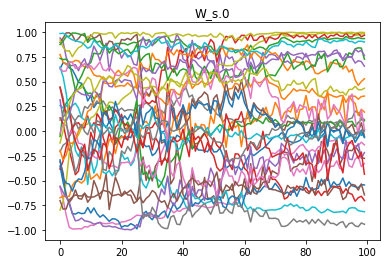

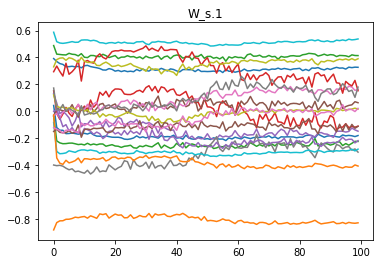

In [122]:
for k in network.state_dict().keys():
    if not 'f_s' in k:
        w_s = [w_dict[k] for w_dict in metric_dict['weights']]
        w_s = np.stack(w_s, 0)
        plt.figure()
        plt.plot(w_s)
        plt.title(k)
        plt.show()

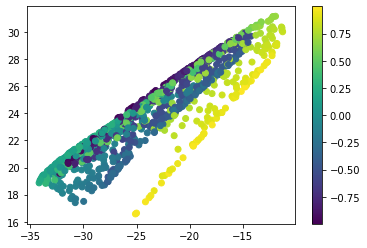

In [123]:
X_s = network.forward(inpt_test_torch.to(training_parameters['device']))
outpt_val_pred = to_numpy(X_s[-1])

plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test
           )
plt.colorbar()
plt.show()

### Meta-iterations

In [159]:
opt = optim.Adam(get_grad_params(network.parameters()),
                 lr=training_parameters['lr_theta'])

In [160]:
ITER_META = 100
EPOCHS_META = 10
EPOCHS_HEBB = 10

metric_dict = defaultdict(list)

meta_switch_times = defaultdict(list)
ordinary_switch_times = defaultdict(list)

training_parameters['progress_bar'] = False
training_parameters['weight_saver'] = None


for meta_iter in tqdm(range(ITER_META)):
    
    print(f'Doing {meta_iter} META iteration')
    
    meta_switch_times['train'].append(len(metric_dict['criterion_train']))
    meta_switch_times['val'].append(len(metric_dict['criterion_val']))
    
    # training meta-parameters usign BP
    training_parameters['learning_type'] = "BP"
    training_parameters['epochs'] = EPOCH_META
    criterion_kwargs['skip_train'] = False
    criterion_kwargs['skip_val'] = False
    
    
    if EPOCH_META > 0:
        network, opt, metric_dict = train(network, 
                                      opt=opt, 
                                      criterion=criterion,
                                      criterion_kwargs=criterion_kwargs,
                                      parameters=training_parameters,
                                      train_dataloader=dataset_train,
                                      val_dataloader=dataset_test, 
                                      metric_dict=metric_dict,
                                      val_metrics=None
                                      )
    
                                  
    ordinary_switch_times['train'].append(len(metric_dict['criterion_train']))
    ordinary_switch_times['val'].append(len(metric_dict['criterion_val']))
    
    
    # training connectivity using local rule
    training_parameters['learning_type'] = LEARNING_TYPE
    training_parameters['batch_size'] = 1
    training_parameters['epochs'] = EPOCHS_HEBB
    criterion_kwargs['skip_train'] = True
    criterion_kwargs['skip_val'] = False

    network, _, metric_dict = train(network, 
                                  opt=None, 
                                  criterion=criterion,
                                  criterion_kwargs=criterion_kwargs,
                                  parameters=training_parameters,
                                  train_dataloader=train_hebb_dataloader,
                                  val_dataloader=dataset_test, 
                                  metric_dict=metric_dict,
                                  val_metrics=None
                                  )

  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

Doing 0 META iteration


  1%|█▎                                                                                                                              | 1/100 [00:08<13:30,  8.19s/it]

Doing 1 META iteration


  2%|██▌                                                                                                                             | 2/100 [00:16<13:19,  8.16s/it]

Doing 2 META iteration


  3%|███▊                                                                                                                            | 3/100 [00:24<13:11,  8.16s/it]

Doing 3 META iteration


  4%|█████                                                                                                                           | 4/100 [00:32<13:03,  8.16s/it]

Doing 4 META iteration


  5%|██████▍                                                                                                                         | 5/100 [00:40<12:55,  8.16s/it]

Doing 5 META iteration


  6%|███████▋                                                                                                                        | 6/100 [00:48<12:46,  8.16s/it]

Doing 6 META iteration


  7%|████████▉                                                                                                                       | 7/100 [00:57<12:38,  8.16s/it]

Doing 7 META iteration


  8%|██████████▏                                                                                                                     | 8/100 [01:05<12:30,  8.16s/it]

Doing 8 META iteration


  9%|███████████▌                                                                                                                    | 9/100 [01:13<12:22,  8.16s/it]

Doing 9 META iteration


 10%|████████████▋                                                                                                                  | 10/100 [01:21<12:14,  8.16s/it]

Doing 10 META iteration


 11%|█████████████▉                                                                                                                 | 11/100 [01:29<12:06,  8.16s/it]

Doing 11 META iteration


 12%|███████████████▏                                                                                                               | 12/100 [01:37<11:58,  8.17s/it]

Doing 12 META iteration


 13%|████████████████▌                                                                                                              | 13/100 [01:46<11:50,  8.16s/it]

Doing 13 META iteration


 14%|█████████████████▊                                                                                                             | 14/100 [01:54<11:42,  8.16s/it]

Doing 14 META iteration


 15%|███████████████████                                                                                                            | 15/100 [02:02<11:31,  8.14s/it]

Doing 15 META iteration


 16%|████████████████████▎                                                                                                          | 16/100 [02:10<11:21,  8.12s/it]

Doing 16 META iteration


 17%|█████████████████████▌                                                                                                         | 17/100 [02:18<11:12,  8.10s/it]

Doing 17 META iteration


 18%|██████████████████████▊                                                                                                        | 18/100 [02:26<11:03,  8.10s/it]

Doing 18 META iteration


 19%|████████████████████████▏                                                                                                      | 19/100 [02:34<10:55,  8.09s/it]

Doing 19 META iteration


 20%|█████████████████████████▍                                                                                                     | 20/100 [02:42<10:46,  8.08s/it]

Doing 20 META iteration


 21%|██████████████████████████▋                                                                                                    | 21/100 [02:50<10:38,  8.08s/it]

Doing 21 META iteration


 22%|███████████████████████████▉                                                                                                   | 22/100 [02:58<10:30,  8.08s/it]

Doing 22 META iteration


 23%|█████████████████████████████▏                                                                                                 | 23/100 [03:06<10:22,  8.08s/it]

Doing 23 META iteration


 24%|██████████████████████████████▍                                                                                                | 24/100 [03:15<10:13,  8.08s/it]

Doing 24 META iteration


 25%|███████████████████████████████▊                                                                                               | 25/100 [03:23<10:05,  8.08s/it]

Doing 25 META iteration


 26%|█████████████████████████████████                                                                                              | 26/100 [03:31<09:57,  8.08s/it]

Doing 26 META iteration


 27%|██████████████████████████████████▎                                                                                            | 27/100 [03:39<09:50,  8.09s/it]

Doing 27 META iteration


 28%|███████████████████████████████████▌                                                                                           | 28/100 [03:47<09:42,  8.09s/it]

Doing 28 META iteration


 29%|████████████████████████████████████▊                                                                                          | 29/100 [03:55<09:34,  8.09s/it]

Doing 29 META iteration


 30%|██████████████████████████████████████                                                                                         | 30/100 [04:03<09:25,  8.08s/it]

Doing 30 META iteration


 31%|███████████████████████████████████████▎                                                                                       | 31/100 [04:11<09:17,  8.08s/it]

Doing 31 META iteration


 32%|████████████████████████████████████████▋                                                                                      | 32/100 [04:19<09:09,  8.08s/it]

Doing 32 META iteration


 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [04:27<09:01,  8.08s/it]

Doing 33 META iteration


 34%|███████████████████████████████████████████▏                                                                                   | 34/100 [04:35<08:53,  8.08s/it]

Doing 34 META iteration


 35%|████████████████████████████████████████████▍                                                                                  | 35/100 [04:43<08:45,  8.08s/it]

Doing 35 META iteration


 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [04:52<08:36,  8.08s/it]

Doing 36 META iteration


 37%|██████████████████████████████████████████████▉                                                                                | 37/100 [05:00<08:28,  8.08s/it]

Doing 37 META iteration


 38%|████████████████████████████████████████████████▎                                                                              | 38/100 [05:08<08:20,  8.08s/it]

Doing 38 META iteration


 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [05:16<08:12,  8.08s/it]

Doing 39 META iteration


 40%|██████████████████████████████████████████████████▊                                                                            | 40/100 [05:24<08:04,  8.08s/it]

Doing 40 META iteration


 41%|████████████████████████████████████████████████████                                                                           | 41/100 [05:32<07:56,  8.08s/it]

Doing 41 META iteration


 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [05:40<07:48,  8.08s/it]

Doing 42 META iteration


 43%|██████████████████████████████████████████████████████▌                                                                        | 43/100 [05:48<07:40,  8.08s/it]

Doing 43 META iteration


 44%|███████████████████████████████████████████████████████▉                                                                       | 44/100 [05:56<07:32,  8.08s/it]

Doing 44 META iteration


 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [06:04<07:25,  8.10s/it]

Doing 45 META iteration


 46%|██████████████████████████████████████████████████████████▍                                                                    | 46/100 [06:12<07:16,  8.09s/it]

Doing 46 META iteration


 47%|███████████████████████████████████████████████████████████▋                                                                   | 47/100 [06:20<07:09,  8.10s/it]

Doing 47 META iteration


 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [06:29<07:02,  8.12s/it]

Doing 48 META iteration


 49%|██████████████████████████████████████████████████████████████▏                                                                | 49/100 [06:37<06:54,  8.13s/it]

Doing 49 META iteration


 50%|███████████████████████████████████████████████████████████████▌                                                               | 50/100 [06:45<06:46,  8.13s/it]

Doing 50 META iteration


 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [06:53<06:38,  8.14s/it]

Doing 51 META iteration


 52%|██████████████████████████████████████████████████████████████████                                                             | 52/100 [07:01<06:31,  8.15s/it]

Doing 52 META iteration


 53%|███████████████████████████████████████████████████████████████████▎                                                           | 53/100 [07:09<06:23,  8.16s/it]

Doing 53 META iteration


 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [07:18<06:15,  8.16s/it]

Doing 54 META iteration


 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 55/100 [07:26<06:06,  8.16s/it]

Doing 55 META iteration


 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [07:34<05:58,  8.16s/it]

Doing 56 META iteration


 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [07:42<05:50,  8.16s/it]

Doing 57 META iteration


 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 58/100 [07:50<05:42,  8.16s/it]

Doing 58 META iteration


 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 59/100 [07:58<05:34,  8.16s/it]

Doing 59 META iteration


 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [08:07<05:26,  8.17s/it]

Doing 60 META iteration


 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 61/100 [08:15<05:18,  8.17s/it]

Doing 61 META iteration


 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 62/100 [08:23<05:10,  8.16s/it]

Doing 62 META iteration


 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [08:31<05:02,  8.16s/it]

Doing 63 META iteration


 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 64/100 [08:39<04:53,  8.16s/it]

Doing 64 META iteration


 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 65/100 [08:47<04:45,  8.16s/it]

Doing 65 META iteration


 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [08:56<04:37,  8.16s/it]

Doing 66 META iteration


 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 67/100 [09:04<04:29,  8.16s/it]

Doing 67 META iteration


 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 68/100 [09:12<04:20,  8.13s/it]

Doing 68 META iteration


 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [09:20<04:11,  8.12s/it]

Doing 69 META iteration


 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/100 [09:28<04:03,  8.10s/it]

Doing 70 META iteration


 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 71/100 [09:36<03:54,  8.10s/it]

Doing 71 META iteration


 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [09:44<03:46,  8.09s/it]

Doing 72 META iteration


 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 73/100 [09:52<03:38,  8.09s/it]

Doing 73 META iteration


 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 74/100 [10:00<03:30,  8.09s/it]

Doing 74 META iteration


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [10:08<03:22,  8.09s/it]

Doing 75 META iteration


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 76/100 [10:16<03:14,  8.09s/it]

Doing 76 META iteration


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 77/100 [10:24<03:05,  8.08s/it]

Doing 77 META iteration


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [10:33<02:58,  8.10s/it]

Doing 78 META iteration


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 79/100 [10:41<02:50,  8.11s/it]

Doing 79 META iteration


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 80/100 [10:49<02:42,  8.12s/it]

Doing 80 META iteration


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [10:57<02:34,  8.13s/it]

Doing 81 META iteration


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 82/100 [11:05<02:26,  8.14s/it]

Doing 82 META iteration


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 83/100 [11:13<02:18,  8.14s/it]

Doing 83 META iteration


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [11:22<02:10,  8.18s/it]

Doing 84 META iteration


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 85/100 [11:30<02:04,  8.29s/it]

Doing 85 META iteration


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 86/100 [11:38<01:55,  8.26s/it]

Doing 86 META iteration


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [11:47<01:46,  8.23s/it]

Doing 87 META iteration


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 88/100 [11:55<01:38,  8.22s/it]

Doing 88 META iteration


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 89/100 [12:03<01:30,  8.21s/it]

Doing 89 META iteration


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [12:11<01:22,  8.20s/it]

Doing 90 META iteration


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 91/100 [12:19<01:13,  8.19s/it]

Doing 91 META iteration


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [12:27<01:05,  8.18s/it]

Doing 92 META iteration


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [12:36<00:57,  8.18s/it]

Doing 93 META iteration


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 94/100 [12:44<00:48,  8.15s/it]

Doing 94 META iteration


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 95/100 [12:52<00:40,  8.16s/it]

Doing 95 META iteration


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [13:00<00:32,  8.16s/it]

Doing 96 META iteration


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [13:08<00:24,  8.18s/it]

Doing 97 META iteration


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [13:19<00:17,  8.85s/it]

Doing 98 META iteration


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [13:30<00:09,  9.63s/it]

Doing 99 META iteration


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:38<00:00,  8.19s/it]


### Visualization

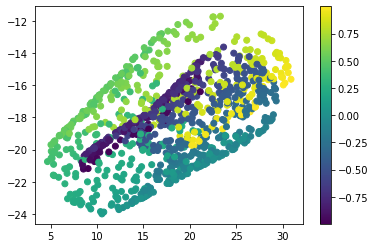

In [162]:
X_s = network.forward(inpt_test_torch.to(training_parameters['device']))
outpt_val_pred = to_numpy(X_s[-1])

plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test
           )
plt.colorbar()
plt.show()

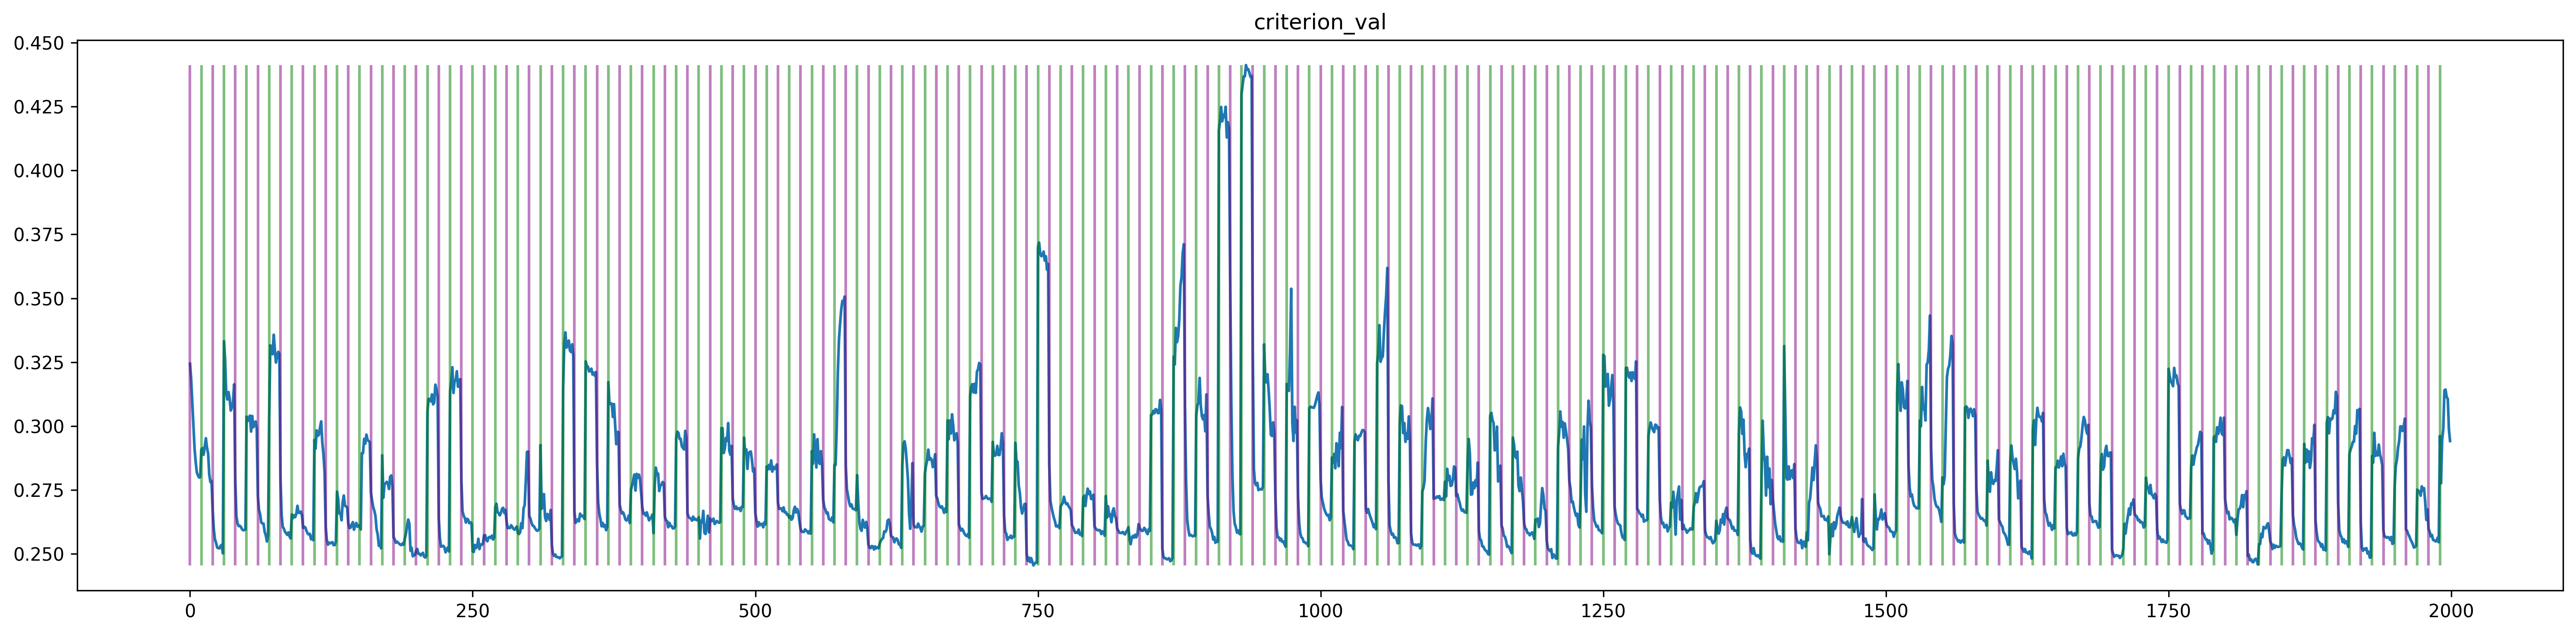

In [166]:
plt.figure(figsize=(20,5), dpi=300)

ax2 = plt.subplot(1,1,1)
ax2.plot(metric_dict['criterion_val'])
ax2.set_title('criterion_val')

#####
cval_min = min(metric_dict['criterion_val'])
cval_max = max(metric_dict['criterion_val'])

ax2.vlines(meta_switch_times['val'], \
           cval_min, \
           cval_max, \
           color='purple', alpha=0.5)

ax2.vlines(ordinary_switch_times['val'], \
           cval_min, \
           cval_max, \
           color='green', alpha=0.5)
####

plt.tight_layout()
plt.show()

In [184]:
# criterion_meta = defaultdict(list)
# criterion_ordinary = defaultdict(list)

# for phase in ['val']:
#     for t in meta_switch_times[phase]:
#         criterion_meta[phase] += metric_dict[f'criterion_{phase}'][t:t+EPOCHS_META] 
        
#     for t in ordinary_switch_times[phase]:
#         criterion_ordinary[phase] += metric_dict[f'criterion_{phase}'][t:t+EPOCHS_HEBB] 

In [164]:
# n_fs = len(network.f_s)
# ξ = torch.linspace(-4,4,1000).to(device)

# for layer in range(n_fs):
#     f_theta = network.f_s[layer]
#     n_neurons = f_theta.input_dim
#     y = torch.stack([ξ for _ in range(n_neurons)],0) # [n_neurons, T]
    
#     f = to_numpy(f_theta(y)) # [n_neurons, T]
    
#     fig, axes = plt.subplots(ncols=n_neurons, nrows=1, figsize=(n_neurons*3,3))
    
#     for j,ax in enumerate(axes):
#         ax.plot(to_numpy(ξ), f[j])
#         ax.set_title(f'Neuron: {j}')
        
#     fig.suptitle(f'Layer: {layer}', y=1.1, color='blue')
    
# plt.tight_layout()
# plt.show()

# Adjacent updates

In [21]:
from train_utils import criterion_rule

In [28]:
W_1 = nn.Parameter(torch.zeros(10, 3), requires_grad=False).to(device)
f_1 = universal_approximator(10, requires_grad=True).to(device)

W_2 = nn.Parameter(torch.zeros(10, 10), requires_grad=False).to(device)
f_2 = universal_approximator(10, requires_grad=True).to(device)

W_3 = nn.Parameter(torch.zeros(2, 10), requires_grad=False).to(device)
f_3 = universal_approximator(2, requires_grad=True).to(device)

In [42]:
opt = optim.Adam([{'params':f_1.parameters()},
                  {'params':f_2.parameters()},
                  {'params':f_3.parameters()},
                  {'params':W_1},
                  {'params':W_2},
                  {'params':W_3}],
                 lr=1e-3)

In [ ]:
#   def hebbian_learning_step(self, 
#                               X_s, 
#                               readout=None,
#                               learning_type='Oja', 
#                               learning_rate=1e-1, 
#                               weight_decay=1e-1):
        
#         '''
#         X_s: [[d_1,], ..., [d_k,T]] - layer activations
#         readout: [d,T] - ground-truth output
#         '''
        
#         inp = X_s[0] 
#         # hebbian update for intermediate layers
#         for i, W in enumerate(self.W_s, start=1):
#             out = X_s[i]
            
#             dW = self.hebbian_update(W.data, inp, out, learning_type=learning_type, weight_decay=weight_decay)
#             W.data = W.data + learning_rate*dW
#             W.data = W.data / torch.norm(W.data, dim=1, keepdim=True)
#             inp = out
            
#         if self.add_readout:
#             # delta-rule update for the readout layer
#             delta = readout - X_s[-1]  # [1,T]
#             dW_out = delta@inp.T
#             self.W_out.data = self.W_out.data + learning_rate*dW_out